In [ ]:
#| default_exp training

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Initial setup

### Data

In [ ]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [ ]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [ ]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [ ]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [ ]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). 

$x_i$ may be big values, and therefore, the $e^{x_i}$ may be very large and create computational problems,

The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the **maximum** of the $x_{j}$.

In [ ]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [ ]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [ ]:
test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [ ]:
y_train[:3]

tensor([5, 0, 4])

Get the fifth predictions in row 0; zeroth prediction in the first raw and the fourth prediction in the second row

In [ ]:
sm_pred[0,5],sm_pred[1,0],sm_pred[2,4]

(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

Do the same with one line:

In [ ]:
sm_pred[[0,1,2], y_train[:3]]   #y_train[:3] is 5, 0, 4

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [ ]:
def nll(input, target): 
    """Negative Log Likelihood loss"""
    return -input[range(target.shape[0]), target].mean()

In [ ]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

Then use PyTorch's implementation.

In [ ]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [ ]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

> homework: check each step and understand what and why

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [ ]:
loss_func = F.cross_entropy

In [ ]:
bs=50                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [ ]:
yb = y_train[0:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])

In [ ]:
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [ ]:
preds[:10]

tensor([[-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06],
        [-0.07, -0.14, -0.14, -0.03, -0.00,  0.13, -0.04,  0.03,  0.04,  0.14],
        [-0.19, -0.04,  0.02,  0.21, -0.06, -0.00, -0.08, -0.01, -0.00,  0.02],
        [-0.05, -0.21, -0.07,  0.08,  0.04,  0.08, -0.10, -0.01,  0.09,  0.01],
        [-0.15, -0.19, -0.04,  0.06, -0.05,  0.15, -0.11,  0.01,  0.08,  0.05],
        [-0.11, -0.13, -0.10,  0.00, -0.05,  0.13, -0.07,  0.03,  0.07,  0.17],
        [-0.07, -0.15, -0.01,  0.10, -0.05, -0.03, -0.08, -0.02, -0.00,  0.07],
        [-0.05, -0.20, -0.01,  0.10,  0.02,  0.16, -0.10, -0.05,  0.05,  0.17],
        [-0.11, -0.17, -0.04,  0.06, -0.03, -0.04, -0.07,  0.02,  0.02, -0.00],
        [-0.17, -0.02, -0.12,  0.03, -0.09,  0.06, -0.15,  0.05,  0.02,  0.09]], grad_fn=<SliceBackward0>)

In [ ]:
preds.argmax(dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5])

In [ ]:
#|export
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [ ]:
accuracy(preds, yb)

tensor(0.08)

Random, so it is normal that the accuracy is 10% for 10 digits

In [ ]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for

In [ ]:
#|export
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [ ]:
xb,yb = x_train[:bs],y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.30, 0.08


In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()
    report(loss, preds, yb)

0.11, 0.96
0.13, 0.96
0.12, 0.96


## Using parameters and optim

### Parameters

We created a class Module in notebook `04`, and there is something similar in torch

Use `nn.Module.__setattr__`:

In [ ]:
m1 = nn.Module()
m1.foo = nn.Linear(3,4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [ ]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [ ]:
m1.named_children()

<generator object Module.named_children>

In [ ]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [ ]:
[(i, p) for i, p in enumerate(m1.parameters())]

[(0,
  Parameter containing:
  tensor([[ 0.57,  0.43, -0.30],
          [ 0.13, -0.32, -0.24],
          [ 0.51,  0.04,  0.22],
          [ 0.13, -0.17, -0.24]], requires_grad=True)),
 (1,
  Parameter containing:
  tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True))]

This is the normal way to use this feature

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()
        
#     def __call__(self, x): return self.l2(self.relu(self.l1(x)))
    def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [ ]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [ ]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [ ]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


This makes is easier to perform the parameter update without having to create code for each layer like in nb `03`

In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [ ]:
fit()

0.19, 0.96
0.11, 0.96
0.04, 1.00


Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

Now let's create our own module `MyModule`

In [ ]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}    # dictionary of all the laywers/modules in this module
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)

    def __setattr__(self,k,v):
        """Called by python everytime we set a new attribute"""
        if not k.startswith("_"):   #check k is not not a private attribute. if not, add that into the _modules dict
            self._modules[k] = v
        # call the python __setattr__ to continue what it needs to do
        super().__setattr__(k,v)

    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            # option 1: traditional: 
            # for p in l.parameters(): yield p  
            
            # option 2: 
            yield from l.parameters()

In [ ]:
mdl = MyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [ ]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering modules

In [ ]:
from functools import reduce

We can use the original `layers` approach, but we have to register the modules.

In [ ]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [ ]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): 
            self.add_module(f'layer_{i}', l)
        
    def forward(self, x): 
        return reduce(lambda val,layer: layer(val), self.layers, x)
    
    # above code gives the same result as more traditional code below
#     def forward(self, x):
#         for l in self.layers: 
#             x = l(x)
#         return x

`reduce(function, iterable[, initial]) -> value`

> Apply a function of two arguments cumulatively to the items of a sequence or iterable, from left to right, so as to reduce the iterable to a single value.  
>
> For example, `reduce(lambda x, y: x+y, [1, 2, 3, 4, 5])` calculates `((((1+2)+3)+4)+5)`.  If initial is present, it is placed before the items of the iterable in the calculation, and serves as a default when the iterable is empty.

In [ ]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
model(xb).shape

torch.Size([50, 10])

### nn.ModuleList

`nn.ModuleList` does this for us.

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [ ]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [ ]:
fit()

0.12, 0.96
0.11, 0.96
0.07, 0.98


### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.16, 0.94
0.13, 0.96
0.08, 0.96


(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

In [ ]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

In [ ]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr

    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
opt = Optimizer(model.parameters())

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.18, 0.94
0.13, 0.96
0.11, 0.94


PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later)

In [ ]:
from torch import optim

In [ ]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [ ]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.33, grad_fn=<NllLossBackward0>)

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.12, 0.98
0.09, 0.98
0.07, 0.98


## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[s]
    yb = y_train[s]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[s]
```

In [ ]:
#|export
class Dataset():
    def __init__(self, x, y): 
        self.x, self.y = x, y

    def __len__(self): 
        return len(self.x)
    
    def __getitem__(self, i): 
        """Returns a the tuple x, y for the index"""
        return self.x[i], self.y[i]

In [ ]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

Now that we have defined a `__get_item__` method for `Dataset`, it becomes possible to slice the dataset like a list of an array `[i], [i:j], ...`

In [ ]:
xb, yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [ ]:
model,opt = get_model()

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i:min(n,i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.17, 0.96
0.11, 0.94
0.09, 0.96


### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

So, we need to create an iterator. A dataloader is an iterator. We will need a dataset and a batch size

In [ ]:
class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): 
            yield self.ds[i:i+self.bs]

In [ ]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [ ]:
xb,yb = next(iter(valid_dl))
xb.shape

torch.Size([50, 784])

In [ ]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4])

tensor(3)

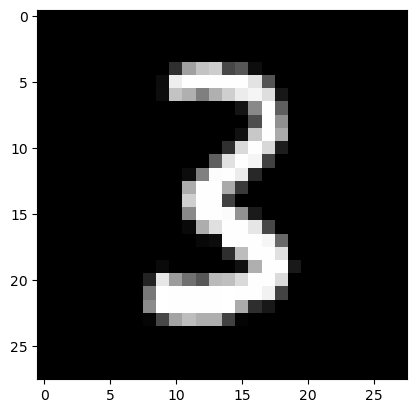

In [ ]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [ ]:
model, opt = get_model()

Now the loop is much cleaner: `for xb, yb in train_dl`

In [ ]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [ ]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.11, 0.98
0.09, 0.98
0.06, 1.00


(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [ ]:
import random

In [ ]:
class Sampler():
    """Returns a set of indexes shuffled or not"""
    def __init__(self, ds, shuffle=False): 
        self.n, self.shuffle = len(ds), shuffle
        
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: 
            random.shuffle(res)
        return iter(res)

In [ ]:
from itertools import islice

In [ ]:
ss = Sampler(train_ds)

In [ ]:
it = iter(ss)
for o in range(5): print(next(it))

0
1
2
3
4


In [ ]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [ ]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[49896, 7225, 9113, 31119, 6246]

In [ ]:
import fastcore.all as fc

In [ ]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): 
#         self.sampler, self.bs, self.drop_last = sampler, bs, drop_last
        fc.store_attr()

    def __iter__(self): 
        yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

`fastcore.store_attr()` is a utility function to store all values passed as attributes in `__init__` as class properties

In [ ]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[12022, 42097, 13632, 26586],
 [34321, 22711, 4581, 6549],
 [12685, 21184, 10911, 9108],
 [12092, 1608, 22472, 7169],
 [12931, 748, 31851, 35138]]

In [ ]:
def collate(b):
    """b is a set of tuples (x,y). Collate stacks all x into one tensor and all y into one tensor"""
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [ ]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): 
        fc.store_attr()
    def __iter__(self): 
        yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [ ]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [ ]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

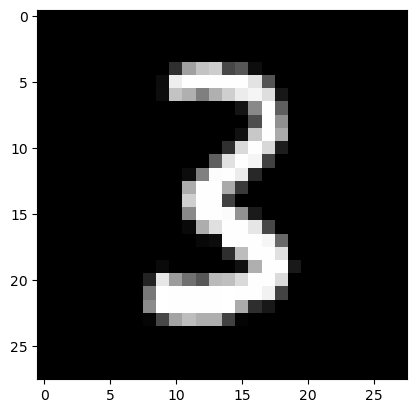

In [ ]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [ ]:
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [ ]:
model,opt = get_model()

In [ ]:
fit()

0.17, 0.92
0.04, 0.98
0.12, 0.94


The features for dataset above are the features that PyTorch has.

> Homework: work with this and experiment different features and paramaters.

### Multiprocessing DataLoader

In pytorch, the code `yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)` can be run on different processors for efficiency. Below is a simple way to do something similar (share the load in parallel)

In [ ]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

Slicing the dataset `[3,6,8,1]` is the same as calling `.__getitem__([3,6,8,1])`

In [ ]:
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [ ]:
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

We can use `map`: takes a sequence and calls a function on each sequence element

In [ ]:
for o in map(train_ds.__getitem__, ([3,6], [8,1])):
    print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


This allows us to control the split of dataset into several pools

In [ ]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

Starts two workers and assigns part of the data for each

In [ ]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [ ]:
# xb,yb = next(it)
# xb.shape,yb.shape

### PyTorch DataLoader

In [ ]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [ ]:
train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [ ]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [ ]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.10, 0.94
0.10, 0.96
0.27, 0.98


(tensor(0.05, grad_fn=<NllLossBackward0>), tensor(0.98))

PyTorch can auto-generate the BatchSampler for us:

In [ ]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

PyTorch can also generate the Sequential/RandomSamplers too:

In [ ]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [ ]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


0.21, 0.14


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


0.15, 0.16


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


0.05, 0.10


(tensor(0.05, grad_fn=<NllLossBackward0>), tensor(0.98))

Our dataset actually already knows how to sample a batch of indices all at once:

In [ ]:
train_ds[[4,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

...that means that we can actually skip the batch_sampler and collate_fn entirely:

In [ ]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

# Note: train_samp and valid_samp are BatchSampler

In [ ]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [ ]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                preds = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(preds,yb).item() * n
                tot_acc  += accuracy (preds,yb).item() * n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [ ]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))
#  use twice the batch size for validation because there is no backprop

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [ ]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()

In [ ]:
%time loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.13792345684953033 0.9607000052928925
1 0.11676023268606514 0.965100005865097
2 0.10700133341364562 0.9677000057697296
3 0.10354992995271459 0.9692000079154969
4 0.10782093483954668 0.971400009393692


## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()